In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers,Input,optimizers

In [2]:

google = pd.read_csv("GOOG.csv")

def paint(data):
    data = data.iloc[::-1]
    data = data.reset_index(drop=True)
    #data['Label'] = np.where(data['adj close'].shift(-1) > data['adj close'], 1, 0)
    #data['Label'] = (data['close'] > data['open']).astype(int)
    return data

google = paint(google)


tweets = pd.read_csv("D:\johnny的文件夹\FDU 课程\大二下\大数据商务分析\Final project\data\Tweet\Tweet.csv")
company_tweets = pd.read_csv(
    "D:\johnny的文件夹\FDU 课程\大二下\大数据商务分析\Final project\data\Tweet\Company_Tweet.csv")
tweets.drop('writer', axis=1, inplace=True)
df_tweets = pd.merge(tweets, company_tweets, on='tweet_id', how='left')
df_tweets['post_date'] = pd.to_datetime(df_tweets['post_date'], unit='s')
df_tweets['post_date'] = df_tweets['post_date'].dt.strftime('%Y-%m-%d')
df_tweets.drop('tweet_id', axis=1, inplace=True)
df_tweets['tweet_score'] = 1 * df_tweets['comment_num'] + 1 * df_tweets['retweet_num'] + 1.2 * df_tweets['like_num']
df_tweets = df_tweets[df_tweets['tweet_score'] >= 50].reset_index()
df_tweets.drop('index', axis=1, inplace=True)
df_tweets.drop('comment_num', axis=1, inplace=True)
df_tweets.drop('retweet_num', axis=1, inplace=True)
df_tweets.drop('like_num', axis=1, inplace=True)

df_tweets.rename(columns={'post_date': 'date'}, inplace=True)
df_tweets['date'] = pd.to_datetime(df_tweets['date'])

def explore(df, company):
    df1 = df[df['ticker_symbol'] == company]
    score = df1.groupby('date')['tweet_score'].sum()
    df1 = pd.concat([score], axis=1)
    df1 = df1.reset_index()
    return df1
google_tweets = explore(df_tweets, 'GOOG')


def make_stock(stock, tweet):
    stock['date'] = pd.to_datetime(stock['date'])
    tweet['date'] = pd.to_datetime(tweet['date'])

    start_date = '2015-01-01'
    end_date = '2019-12-31'
    stock = stock.loc[(stock['date'] >= start_date) & (stock['date'] <= end_date)]
    result = pd.merge(stock, tweet, on='date', how='left')
    return result
google = make_stock(google, google_tweets).dropna()


In [3]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

df=pd.DataFrame(google,columns=['date','open','close','tweet_score'])
data = df[['open','close','tweet_score']].values
# 归一化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
print(scaled_data)

# 创建数据集
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, :2])  
    return np.array(X), np.array(y)

time_step = 100
X, y = create_dataset(scaled_data, time_step)

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


[[1.86197020e-02 8.12345329e-03 1.23049487e-02]
 [4.36127674e-03 0.00000000e+00 2.94159608e-01]
 [0.00000000e+00 1.29836085e-02 5.97414177e-03]
 ...
 [1.00000000e+00 9.86466463e-01 5.74230941e-02]
 [9.99580187e-01 9.89154510e-01 7.13330361e-04]
 [9.84431313e-01 9.70747622e-01 3.19215337e-02]]


In [4]:
# 创建LSTM模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 3)))  # 输入形状为(time_step, 2)
model.add(LSTM(units=50))
model.add(Dense(2))  # 输出一个值，即预测的closing价格

model.compile(optimizer='adam', loss='mean_squared_error')

# 训练模型
model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 反归一化
train_predict_full = np.concatenate((train_predict, np.zeros((train_predict.shape[0], 1))), axis=1)
test_predict_full = np.concatenate((test_predict, np.zeros((test_predict.shape[0], 1))), axis=1)
train_predict = scaler.inverse_transform(train_predict_full)[:, :2]
test_predict = scaler.inverse_transform(test_predict_full)[:, :2]


Epoch 1/40


C:\Users\johnn\PycharmProjects\Deep Learning\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.3173 - val_loss: 0.0097
Epoch 2/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0209 - val_loss: 0.0349
Epoch 3/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0097 - val_loss: 0.0110
Epoch 4/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0053 - val_loss: 0.0104
Epoch 5/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0038 - val_loss: 0.0102
Epoch 6/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0030 - val_loss: 0.0068
Epoch 7/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0026 - val_loss: 0.0061
Epoch 8/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0025 - val_loss: 0.0054
Epoch 9/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0027 - val_loss: 0.0061
Epoch 10/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0025 - val_loss: 0.0049
Epoch 11/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0026 - val_loss: 0.0038
Epoch 12/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0025 - val_l

In [5]:
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, train_predict)
test_mse = mean_squared_error(y_test, test_predict)
print(train_mse, test_mse)
# accuracy, mse
# 相对于原始数据的涨跌

958903.1743024071 1367507.2065101687


In [6]:
open_predict = np.concatenate([train_predict[:,0], test_predict[:,0]], axis=0)
close_predict = np.concatenate([train_predict[:,1], test_predict[:,1]], axis=0)


In [7]:
open_predict.shape

(439,)

Text(0.5, 1.0, 'Stock Price Prediction')

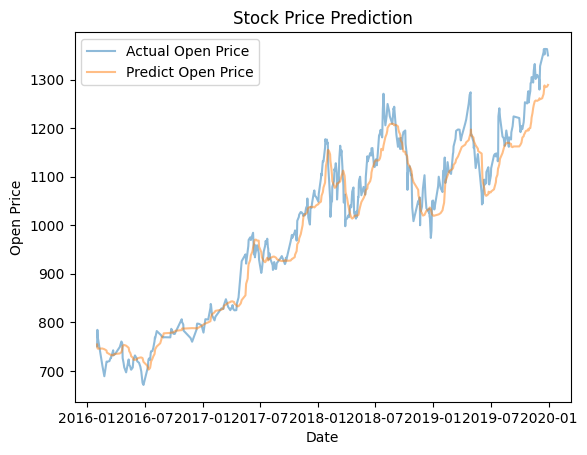

In [8]:
import matplotlib.pyplot as plt
plt.plot(df['date'][time_step:], df['open'][time_step:], label='Actual Open Price', alpha=0.5)
plt.plot(df['date'][time_step:], open_predict, label='Predict Open Price', alpha=0.5)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Stock Price Prediction')

Text(0.5, 1.0, 'Stock Price Prediction')

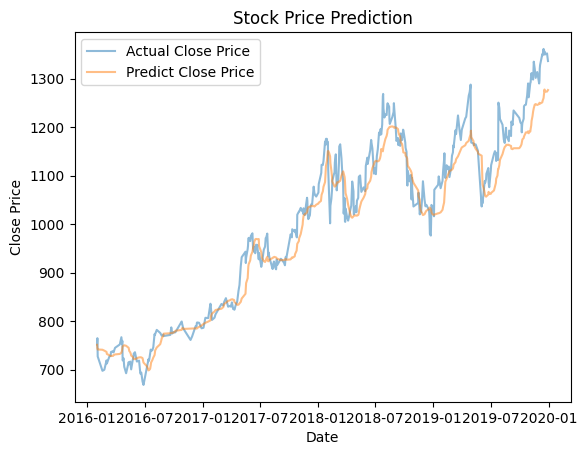

In [9]:
plt.plot(df['date'][time_step:], df['close'][time_step:], label='Actual Close Price', alpha=0.5)
plt.plot(df['date'][time_step:], close_predict, label='Predict Close Price', alpha=0.5)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price Prediction')

In [10]:
prediction = pd.DataFrame({'pre_open':open_predict, 'pre_close':close_predict})
prediction

,pre_open,pre_close
0,754.326694,750.934111
1,747.804047,743.731137
2,745.834383,741.350937
3,745.995099,740.822131
4,744.648393,738.970762
...,...,...
434,1281.813431,1271.586255
435,1288.019348,1277.436397
436,1284.468305,1273.117770
437,1285.658409,1273.244355


In [11]:
google.reset_index(inplace=True)
google_stock = pd.concat([google, prediction], axis=1)
google_stock

,index,date,volume,open,high,low,close,adj close,tweet_score,pre_open,pre_close
0,1,2015-01-05,2059800,521.827332,522.894409,511.655243,512.463013,512.463013,77.6,754.326694,750.934111
1,11,2015-01-20,2232000,509.600891,511.096771,504.630524,505.512115,505.512115,709.8,747.804047,743.731137
2,12,2015-01-21,2268700,505.861145,517.858215,504.814026,516.621643,516.621643,63.4,745.834383,741.350937
3,16,2015-01-27,1904000,528.518921,529.246948,516.771179,517.210022,517.210022,546.4,745.995099,740.822131
4,18,2015-01-29,4186300,509.600891,509.690643,499.827728,509.261810,509.261810,145.0,744.648393,738.970762
...,...,...,...,...,...,...,...,...,...,...,...
534,1249,2019-12-18,1522600,1356.599976,1360.469971,1351.000000,1352.619995,1352.619995,79.6,NaN,NaN
535,1250,2019-12-19,1469900,1351.819946,1358.099976,1348.984985,1356.040039,1356.040039,1227.0,NaN,NaN
536,1251,2019-12-20,3315000,1363.349976,1363.640015,1349.000000,1349.589966,1349.589966,178.8,NaN,NaN
537,1255,2019-12-27,1038400,1362.989990,1364.530029,1349.310059,1351.890015,1351.890015,51.6,NaN,NaN


In [12]:
google_stock['pre_Label'] = np.where(google_stock['pre_close'].shift(-1) > google_stock['pre_close'], 1, 0)
google_stock['Label'] = np.where(google_stock['close'].shift(-1) > google_stock['close'], 1, 0)
google_stock.dropna(inplace=True)

In [13]:
google_stock

,index,date,volume,open,high,low,close,adj close,tweet_score,pre_open,pre_close,pre_Label,Label
0,1,2015-01-05,2059800,521.827332,522.894409,511.655243,512.463013,512.463013,77.6,754.326694,750.934111,0,0
1,11,2015-01-20,2232000,509.600891,511.096771,504.630524,505.512115,505.512115,709.8,747.804047,743.731137,0,1
2,12,2015-01-21,2268700,505.861145,517.858215,504.814026,516.621643,516.621643,63.4,745.834383,741.350937,0,1
3,16,2015-01-27,1904000,528.518921,529.246948,516.771179,517.210022,517.210022,546.4,745.995099,740.822131,0,0
4,18,2015-01-29,4186300,509.600891,509.690643,499.827728,509.261810,509.261810,145.0,744.648393,738.970762,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,1030,2019-02-06,2105600,1139.569946,1147.000000,1112.770020,1115.229980,1115.229980,50.4,1281.813431,1271.586255,1,0
435,1031,2019-02-07,2044800,1104.160034,1104.839966,1086.000000,1098.709961,1098.709961,126.8,1288.019348,1277.436397,0,0
436,1032,2019-02-08,1075800,1087.000000,1098.910034,1086.550049,1095.060059,1095.060059,124.0,1284.468305,1273.117770,1,1
437,1034,2019-02-12,1609100,1106.800049,1125.295044,1105.849976,1121.369995,1121.369995,88.6,1285.658409,1273.244355,1,0


In [14]:
TP = ((google_stock['Label'] == 1) & (google_stock['pre_Label'] == 1)).sum()
FP = ((google_stock['Label'] == 0) & (google_stock['pre_Label'] == 1)).sum()
FN = ((google_stock['Label'] == 1) & (google_stock['pre_Label'] == 0)).sum()

# 计算 Precision 和 Recall
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall)
print(precision, recall, f1)

0.5454545454545454 0.6419753086419753 0.5897920604914934


In [15]:
initial_fund = 10000
funds = initial_fund
for index in range(len(google_stock) - 1):
    if google_stock.loc[index, 'pre_Label'] == 1:
        # 在下一行的open买入股票
        funds += (google_stock.loc[index + 1, 'close'] - google_stock.loc[index + 1, 'open'])
print(funds)

10137.89208984375


In [16]:
X = []
y = []
for i in range(len(scaled_data)-100-7+1):
    X.append(scaled_data[i:i+100])
    y.append(scaled_data[i+100+7-1, 1])  
X = np.array(X)
y = np.array(y)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(100, 3)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=40, batch_size=32,validation_data=(X_test, y_test))
predictions = []
for i in range(len(X) - split):
    predictions.append(model.predict(np.expand_dims(X[split+i], axis=0))[0, 0])
predictions = scaler.inverse_transform([[0, pred, 0] for pred in predictions])[:, 1]
print(predictions)

C:\Users\johnn\PycharmProjects\Deep Learning\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.2431 - val_loss: 0.0445
Epoch 2/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0258 - val_loss: 0.0471
Epoch 3/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0131 - val_loss: 0.0090
Epoch 4/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0056 - val_loss: 0.0113
Epoch 5/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0050 - val_loss: 0.0133
Epoch 6/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0046 - val_loss: 0.0093
Epoch 7/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0042 - val_loss: 0.0113
Epoch 8/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0044 - val_loss: 0.0090
Epoch 9/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0039 - val_loss: 0.0098
Epoch 10/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0042 - val_loss: 0.0085
Epoch 11/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0042 - val_loss: 0.0088
Epoch 12/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0

In [18]:
predictions = pd.DataFrame(predictions, columns=['pred'])
num = len(google) - len(predictions)
df = google[num:]
df.reset_index(inplace=True)
stock1 = pd.concat([df, predictions], axis=1)
stock1['pre_Label'] = np.where(stock1['pred'].shift(-1) > stock1['pred'], 1, 0)
stock1['Label'] = np.where(stock1['close'].shift(-1) > stock1['close'], 1, 0)
TP = ((stock1['Label'] == 1) & (stock1['pre_Label'] == 1)).sum()
FP = ((stock1['Label'] == 0) & (stock1['pre_Label'] == 1)).sum()
FN = ((stock1['Label'] == 1) & (stock1['pre_Label'] == 0)).sum()

# 计算 Precision 和 Recall
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall)
print(round(precision,3), round(recall,3), round(f1,3))

0.509 0.659 0.574
